<img src="../img/hu-logo.png" align="right" width="120">

# Logistic Regression: Motivation

In this notebook we will motivate ___Logistic Regression___ (vis-à-vis Linear Regression). 

Specifically, we will look at
- the distribution of the dependent variable
- the functional form of the Logit curve
- probability thresholds

We will also see how we can model more complex (i.e., non-linear) decision boundaries.

In [1]:
import os

import numpy as np
import pandas as pd
    
import sklearn.linear_model
import statsmodels.api as sm

import seaborn as sns
import matplotlib.patches
import matplotlib.colors
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
    "pcolor.shading": "auto",
})

## Background

### Formal representation of the problem

Let's look at a binary classification model

$
\quad y_i = \cases{1 \quad \text{if}\ z_i^* > 0\\0 \quad \text{otherwise}}
$

that represents our hypothesis $h$, with

$
\quad z_i^* = \theta^{(k)} f\left( x_i^{(k)} \right) + \varepsilon_i
$

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $\theta$ are the coefficients (or weights).

Assuming a logistic distribution for the error term leads to a closed form solution for class probabilities

$
\quad p(y_i = 1) =  \displaystyle\frac{
\exp\left\{ z_i \right\}
}{
1 + \exp\left\{ z_i \right\}
}
=
\displaystyle\frac{1}{
1 + \exp\left\{ -z_i \right\}
}
$

### Update equations

Gradient descent starts with an initial guess for $\theta$ and then iterates to minimize the cost function $J$ (i.e., maximize the LL function). With the learning rate $\eta$, it follows

$
\quad\displaystyle \theta_k' \\
\quad\quad= \theta_k - \eta\,\partial_\theta J(\theta) \\
\quad\quad= \theta_k - \eta\,\displaystyle\sum_i \big(h_\theta(x_i) - y_i\big) x_k
$

## Input

Let's define the number of data samples (`N`) and the parameters of the Logit curve (`B`). We will see later in the lecture what these parameters mean.

In [3]:
N = 5_000   # number of data points
B = [-6, 3] # two features

## Generate data

### Implementation of data generating process (DGP)

In [4]:
def generate_data(n, b, seed=501):
    np.random.seed(seed)
    x = np.random.normal(2, 1, n).reshape((-1, 1))  # feature
    z = b[0] + b[1] * x                             # latent variable
    p = 1 / (1 + np.exp(-z))                        # probability (of sample being in class 1)
    y = np.random.binomial(1, p=p).flatten()        # sampled class assignment
    return x, y, p

In [5]:
x, y, p = generate_data(N, B)

### Plot probability distribution

Note that this is of course ___not___ known in reality.

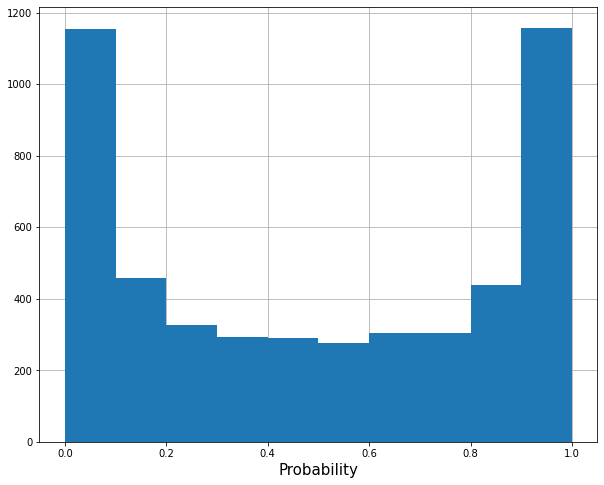

In [6]:
plt.hist(p)
plt.xlabel("Probability")
del p                      # let's delete p so we don't use it accidentally
plt.show()

In [7]:
# create the range of x values we want to look at later
x_predict = np.arange(x.min().round(2), x.max().round(2), .005).reshape(-1, 1)

### Plot the generated data

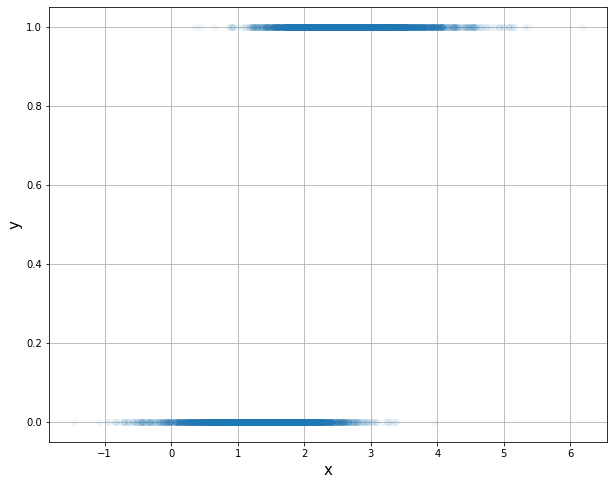

In [8]:
plt.scatter(x, y, alpha=.05)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Linear model

### with `sklearn`

In [9]:
model_linear = sklearn.linear_model.LinearRegression()
model_linear.fit(x, y)
model_linear.coef_, model_linear.intercept_

(array([0.34951902]), -0.20872838871655586)

### with `statsmodels`

In [10]:
sm_ols = sm.OLS(y, sm.add_constant(x))
result_sm_ols = sm_ols.fit()
print(result_sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     4642.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:22:36   Log-Likelihood:                -1986.0
No. Observations:                5000   AIC:                             3976.
Df Residuals:                    4998   BIC:                             3989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2087      0.011    -18.192      0.0

### Predict outcomes and plot result

In [11]:
def predict_plot(m, x, x_true, y_true, title="", lims=None, proba=False):
    plt.scatter(x_true, y_true, alpha=.2, label="True")
    
    plt.plot(x, m.predict(x), label="Predicted", c="darkorange", linewidth=3)
    if proba:
        plt.plot(x, m.predict_proba(x)[:,1], label="Predicted Probability", c="magenta", linewidth=3)
        plt.hlines(y=.5, xmin=x.min(), xmax=x.max(), colors='grey', linestyles="--", linewidth=1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(title)
    if lims:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    plt.show()

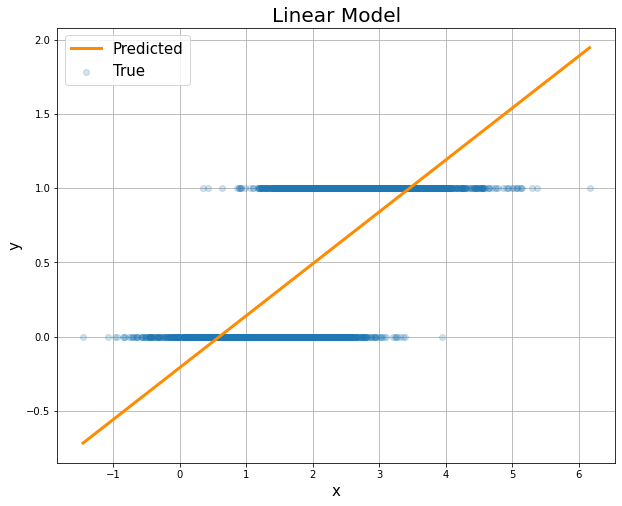

In [12]:
predict_plot(model_linear, x_predict, x, y, "Linear Model")

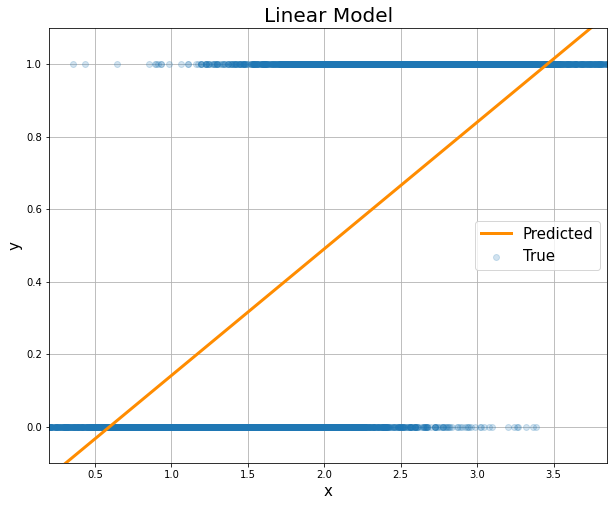

In [13]:
predict_plot(model_linear, x_predict, x, y, "Linear Model", ([0.2, 3.85], [-.1, 1.1]))

## Logistic Regression

- outcomes can only be 0 and 1
- model the probability of class membership
- given a probability threshold, we can turn probabilities in to class assignments

### Logistic function

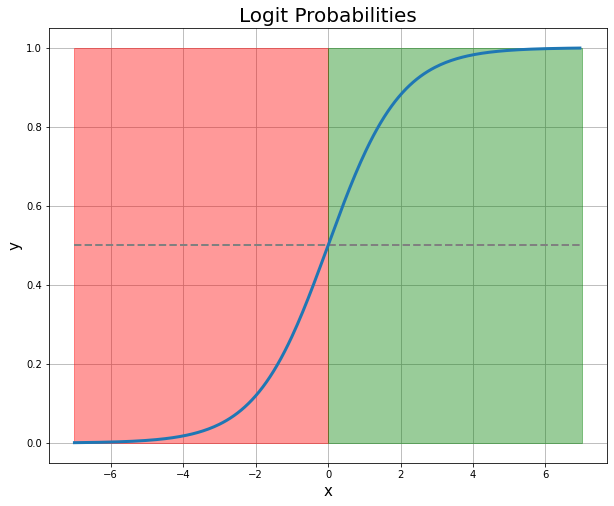

In [14]:
sample_x = np.arange(-7, 7, .05)
sample_y = 1/(1 + np.exp(-sample_x))
fig, ax = plt.subplots(1)
ax.plot(sample_x, sample_y, linewidth=3)
plt.hlines(y=.5, xmin=sample_x.min(), xmax=sample_x.max(), colors='grey', linestyles="--", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
delta = .0
ax.add_patch(matplotlib.patches.Rectangle((-7, 0), 7-delta, 1, linewidth=1, facecolor="r", edgecolor="r", alpha=.4))
ax.add_patch(matplotlib.patches.Rectangle((delta, 0), 7-delta, 1, linewidth=1, facecolor="g", edgecolor="g", alpha=.4))
plt.title("Logit Probabilities")
plt.show()

### with `sklearn`

In [15]:
model_logistic = sklearn.linear_model.LogisticRegression(C=1e9)
result_logistic = model_logistic.fit(x, y)
result_logistic.intercept_, result_logistic.coef_

(array([-6.27042526]), array([[3.10679828]]))

### with `statsmodels`

In [16]:
sm_logit = sm.Logit(y, sm.add_constant(x))
result_sm_logit = sm_logit.fit()
print(result_sm_logit.summary())

Optimization terminated successfully.
         Current function value: 0.353528
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Mon, 30 Nov 2020   Pseudo R-squ.:                  0.4899
Time:                        22:22:36   Log-Likelihood:                -1767.6
converged:                       True   LL-Null:                       -3465.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2705      0.182    -34.467      0.000      -6.627      -5.914
x1             3.1068      0.

### Predict outcomes and plot result

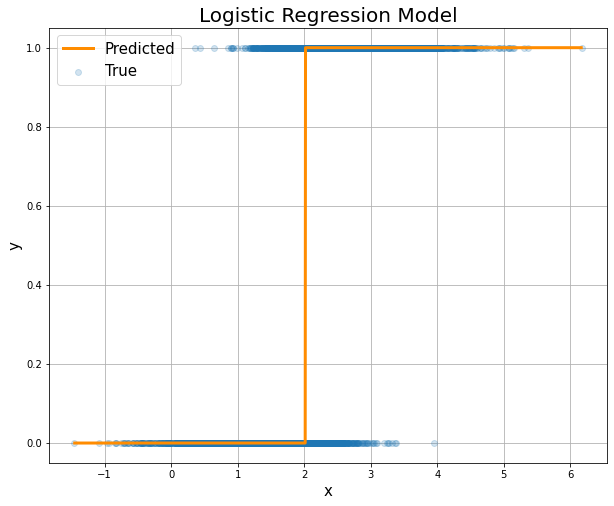

In [17]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model")

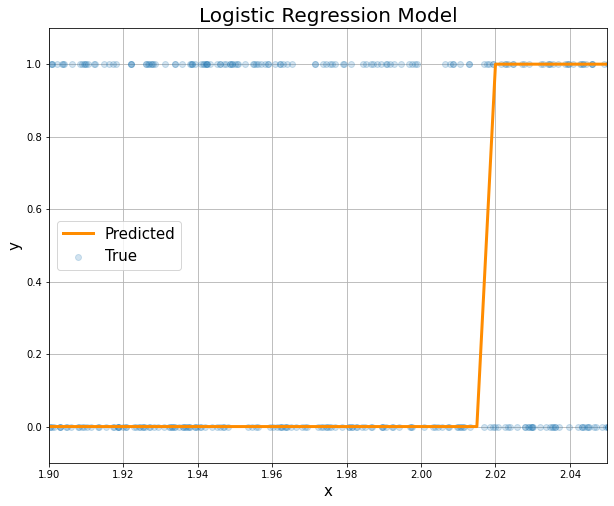

In [18]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model", ([1.9, 2.05], [-.1, 1.1]))

### Let's use probabilities in the plot

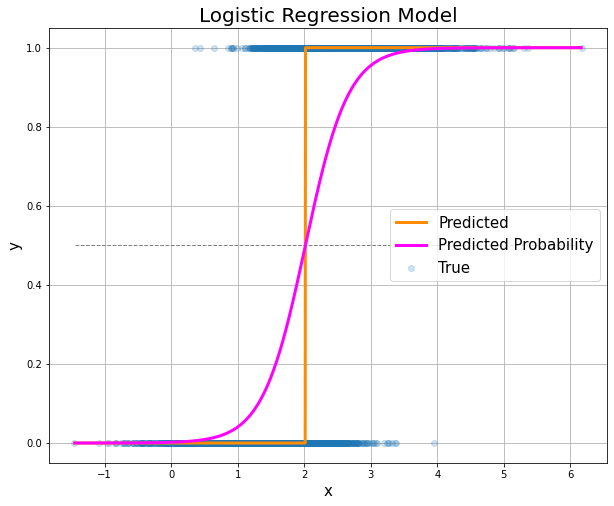

In [19]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model", proba=True)

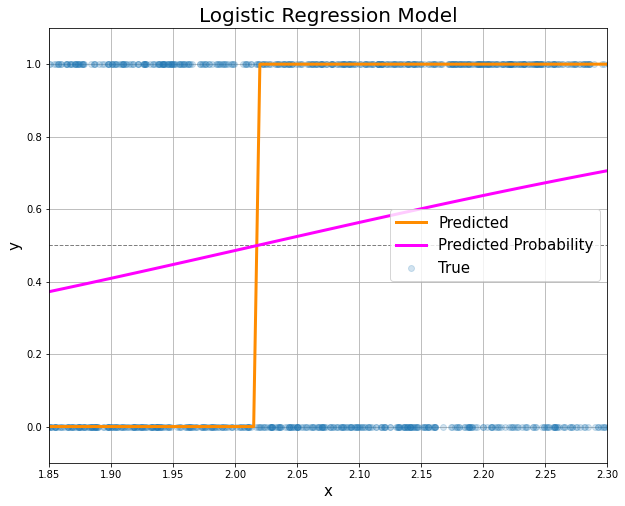

In [20]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model", ([1.85, 2.3], [-.1, 1.1]), proba=True)

<br>
<br>

## What about more complex classification problems?

### Data generation

In [21]:
N = 1_000
np.random.seed(501)
x1 = np.random.uniform(-2, 2, (N, 1))
x2 = np.random.uniform(-2, 2, (N, 1))
x = np.hstack([x1, x2])**2
y = ((x1**2 + x2**2)<1).astype(int).flatten()

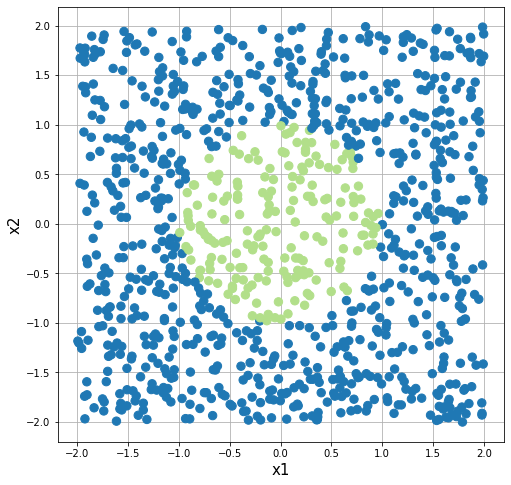

In [22]:
cmap_2 = matplotlib.colors.ListedColormap(sns.color_palette("Paired")[1:3])
fig, axes = plt.subplots(figsize=(8,8))
plt.scatter(x1, x2, c=y, cmap=cmap_2, s=70)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Fit logistic regression with polynomial features

In [23]:
model_logistic = sklearn.linear_model.LogisticRegression()
result_logistic = model_logistic.fit(np.hstack([x1, x2])**2, y)
result_logistic.intercept_, result_logistic.coef_

(array([5.4207463]), array([[-5.52825553, -5.58099957]]))

### Plot decision boundary

In [24]:
n_samples = 1_000
_x1 = np.linspace(-2, 2, n_samples)
_x2 = np.linspace(-2, 2, n_samples)
_X1, _X2 = np.meshgrid(_x1, _x2)
_X = np.hstack([_X1.reshape(-1, 1)**2, _X2.reshape(-1, 1)**2])
Z = result_logistic.intercept_ + _X.dot(result_logistic.coef_.T)
yhat = result_logistic.predict(_X)

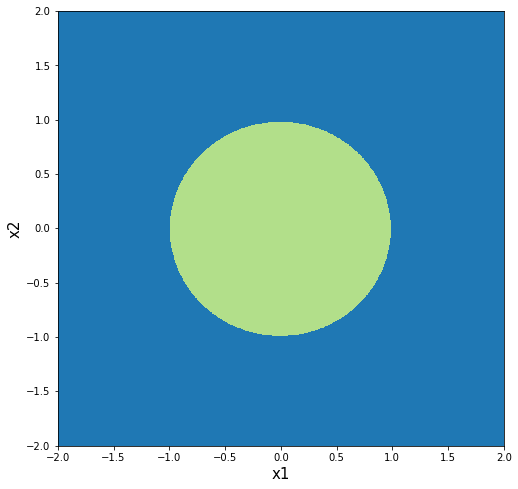

In [25]:
fig, axes = plt.subplots(figsize=(8,8))
plt.pcolormesh(_X1, _X2, yhat.reshape(n_samples, n_samples), cmap=cmap_2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 4 <br>
2020 <br>